In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


1/7 [===>..........................] - ETA: 13s - loss: 0.0170 - STD: 1.0429e-04 - MAE: 0.0734

2/7 [=======>......................] - ETA: 18s - loss: 0.0225 - STD: 2.0011e-04 - MAE: 0.1096

3/7 [===========>..................] - ETA: 7s - loss: 0.0185 - STD: 2.7012e-04 - MAE: 0.1009 

4/7 [================>.............] - ETA: 4s - loss: 0.0173 - STD: 3.5210e-04 - MAE: 0.0912

5/7 [====================>.........] - ETA: 2s - loss: 0.0174 - STD: 4.4283e-04 - MAE: 0.0883

6/7 [========================>.....] - ETA: 0s - loss: 0.0172 - STD: 5.4940e-04 - MAE: 0.0855

7/7 [==============================] - ETA: 0s - loss: 0.0167 - STD: 6.7652e-04 - MAE: 0.0818

7/7 [==============================] - 9s 1s/step - loss: 0.0167 - STD: 6.7652e-04 - MAE: 0.0818 - val_loss: 0.0165 - val_STD: 0.0019 - val_MAE: 0.0796


Epoch 2/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0123 - STD: 0.0018 - MAE: 0.0688

2/7 [=======>......................] - ETA: 1s - loss: 0.0129 - STD: 0.0020 - MAE: 0.0796

3/7 [===========>..................] - ETA: 0s - loss: 0.0136 - STD: 0.0022 - MAE: 0.0868

4/7 [================>.............] - ETA: 0s - loss: 0.0137 - STD: 0.0024 - MAE: 0.0893

5/7 [====================>.........] - ETA: 0s - loss: 0.0136 - STD: 0.0025 - MAE: 0.0878

6/7 [========================>.....] - ETA: 0s - loss: 0.0134 - STD: 0.0026 - MAE: 0.0844

7/7 [==============================] - ETA: 0s - loss: 0.0132 - STD: 0.0027 - MAE: 0.0808

7/7 [==============================] - 2s 235ms/step - loss: 0.0132 - STD: 0.0027 - MAE: 0.0808 - val_loss: 0.0178 - val_STD: 0.0035 - val_MAE: 0.0696


Epoch 3/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0133 - STD: 0.0034 - MAE: 0.0586

2/7 [=======>......................] - ETA: 1s - loss: 0.0133 - STD: 0.0036 - MAE: 0.0585

3/7 [===========>..................] - ETA: 0s - loss: 0.0132 - STD: 0.0038 - MAE: 0.0585

4/7 [================>.............] - ETA: 0s - loss: 0.0130 - STD: 0.0040 - MAE: 0.0591

5/7 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 0.0043 - MAE: 0.0608

6/7 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 0.0046 - MAE: 0.0634

7/7 [==============================] - ETA: 0s - loss: 0.0126 - STD: 0.0049 - MAE: 0.0660

7/7 [==============================] - 2s 241ms/step - loss: 0.0126 - STD: 0.0049 - MAE: 0.0660 - val_loss: 0.0158 - val_STD: 0.0077 - val_MAE: 0.0918


Epoch 4/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0124 - STD: 0.0076 - MAE: 0.0827

2/7 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 0.0079 - MAE: 0.0802

3/7 [===========>..................] - ETA: 1s - loss: 0.0117 - STD: 0.0083 - MAE: 0.0768

4/7 [================>.............] - ETA: 0s - loss: 0.0116 - STD: 0.0086 - MAE: 0.0734

5/7 [====================>.........] - ETA: 0s - loss: 0.0116 - STD: 0.0090 - MAE: 0.0705

6/7 [========================>.....] - ETA: 0s - loss: 0.0115 - STD: 0.0095 - MAE: 0.0681

7/7 [==============================] - ETA: 0s - loss: 0.0114 - STD: 0.0100 - MAE: 0.0664

7/7 [==============================] - 2s 287ms/step - loss: 0.0114 - STD: 0.0100 - MAE: 0.0664 - val_loss: 0.0145 - val_STD: 0.0156 - val_MAE: 0.0683


Epoch 5/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0108 - STD: 0.0153 - MAE: 0.0577

2/7 [=======>......................] - ETA: 0s - loss: 0.0106 - STD: 0.0165 - MAE: 0.0595

3/7 [===========>..................] - ETA: 0s - loss: 0.0104 - STD: 0.0179 - MAE: 0.0614

4/7 [================>.............] - ETA: 0s - loss: 0.0101 - STD: 0.0193 - MAE: 0.0629

5/7 [====================>.........] - ETA: 0s - loss: 0.0100 - STD: 0.0208 - MAE: 0.0636

6/7 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 0.0224 - MAE: 0.0633

7/7 [==============================] - ETA: 0s - loss: 0.0096 - STD: 0.0241 - MAE: 0.0621

7/7 [==============================] - 2s 241ms/step - loss: 0.0096 - STD: 0.0241 - MAE: 0.0621 - val_loss: 0.0114 - val_STD: 0.0386 - val_MAE: 0.0615


Epoch 6/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0081 - STD: 0.0377 - MAE: 0.0513

2/7 [=======>......................] - ETA: 1s - loss: 0.0078 - STD: 0.0398 - MAE: 0.0504

3/7 [===========>..................] - ETA: 1s - loss: 0.0076 - STD: 0.0425 - MAE: 0.0501

4/7 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.0455 - MAE: 0.0500

5/7 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0489 - MAE: 0.0502

6/7 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.0524 - MAE: 0.0504

7/7 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0556 - MAE: 0.0504

7/7 [==============================] - 2s 280ms/step - loss: 0.0068 - STD: 0.0556 - MAE: 0.0504 - val_loss: 0.0078 - val_STD: 0.0820 - val_MAE: 0.0571


Epoch 7/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0786 - MAE: 0.0494

2/7 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0793 - MAE: 0.0490

3/7 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0803 - MAE: 0.0490

4/7 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0816 - MAE: 0.0486

5/7 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0480

6/7 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0846 - MAE: 0.0473

7/7 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0851 - MAE: 0.0465

7/7 [==============================] - 2s 241ms/step - loss: 0.0049 - STD: 0.0851 - MAE: 0.0465 - val_loss: 0.0061 - val_STD: 0.0888 - val_MAE: 0.0498


Epoch 8/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0837 - MAE: 0.0410

2/7 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0405

3/7 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0806 - MAE: 0.0404

4/7 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0808 - MAE: 0.0404

5/7 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0821 - MAE: 0.0404

6/7 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0833 - MAE: 0.0402

7/7 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0843 - MAE: 0.0399

7/7 [==============================] - 2s 240ms/step - loss: 0.0039 - STD: 0.0843 - MAE: 0.0399 - val_loss: 0.0052 - val_STD: 0.0987 - val_MAE: 0.0457


Epoch 9/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0036 - STD: 0.0917 - MAE: 0.0387

2/7 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0940 - MAE: 0.0388

3/7 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0965 - MAE: 0.0388

4/7 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0981 - MAE: 0.0387

5/7 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0984 - MAE: 0.0385

6/7 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0978 - MAE: 0.0382

7/7 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0970 - MAE: 0.0380

7/7 [==============================] - 2s 284ms/step - loss: 0.0035 - STD: 0.0970 - MAE: 0.0380 - val_loss: 0.0049 - val_STD: 0.0995 - val_MAE: 0.0448


Epoch 10/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0928 - MAE: 0.0367

2/7 [=======>......................] - ETA: 1s - loss: 0.0034 - STD: 0.0932 - MAE: 0.0370

3/7 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0936 - MAE: 0.0369

4/7 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0935 - MAE: 0.0367

5/7 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0938 - MAE: 0.0366

6/7 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0947 - MAE: 0.0365

7/7 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0957 - MAE: 0.0364

7/7 [==============================] - 2s 239ms/step - loss: 0.0033 - STD: 0.0957 - MAE: 0.0364 - val_loss: 0.0045 - val_STD: 0.1114 - val_MAE: 0.0425


Epoch 11/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.1029 - MAE: 0.0361

2/7 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0360

3/7 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.1002 - MAE: 0.0360

4/7 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0994 - MAE: 0.0358

5/7 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0991 - MAE: 0.0357

6/7 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0989 - MAE: 0.0356

7/7 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0985 - MAE: 0.0356

7/7 [==============================] - 2s 243ms/step - loss: 0.0031 - STD: 0.0985 - MAE: 0.0356 - val_loss: 0.0043 - val_STD: 0.1034 - val_MAE: 0.0415


Epoch 12/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0030 - STD: 0.0953 - MAE: 0.0348

2/7 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0974 - MAE: 0.0350

3/7 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0989 - MAE: 0.0349

4/7 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0997 - MAE: 0.0349

5/7 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0996 - MAE: 0.0349

6/7 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0995 - MAE: 0.0349

7/7 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0995 - MAE: 0.0348

7/7 [==============================] - 2s 280ms/step - loss: 0.0029 - STD: 0.0995 - MAE: 0.0348 - val_loss: 0.0040 - val_STD: 0.1069 - val_MAE: 0.0409


Epoch 13/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0995 - MAE: 0.0344

2/7 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0986 - MAE: 0.0344

3/7 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0978 - MAE: 0.0343

4/7 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0978 - MAE: 0.0342

5/7 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0983 - MAE: 0.0342

6/7 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0987 - MAE: 0.0342

7/7 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0989 - MAE: 0.0341

7/7 [==============================] - 2s 242ms/step - loss: 0.0028 - STD: 0.0989 - MAE: 0.0341 - val_loss: 0.0037 - val_STD: 0.1078 - val_MAE: 0.0393


Epoch 14/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

2/7 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1000 - MAE: 0.0339

3/7 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.0999 - MAE: 0.0337

4/7 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0998 - MAE: 0.0337

5/7 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0336

6/7 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0994 - MAE: 0.0336

7/7 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0995 - MAE: 0.0335

7/7 [==============================] - 2s 239ms/step - loss: 0.0026 - STD: 0.0995 - MAE: 0.0335 - val_loss: 0.0035 - val_STD: 0.1089 - val_MAE: 0.0388


Epoch 15/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0026 - STD: 0.0991 - MAE: 0.0333

2/7 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0999 - MAE: 0.0332

3/7 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.1002 - MAE: 0.0332

4/7 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.1002 - MAE: 0.0332

5/7 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1002 - MAE: 0.0331

6/7 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1001 - MAE: 0.0331

7/7 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1000 - MAE: 0.0330

7/7 [==============================] - 2s 282ms/step - loss: 0.0025 - STD: 0.1000 - MAE: 0.0330 - val_loss: 0.0033 - val_STD: 0.1098 - val_MAE: 0.0379


Epoch 16/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0999 - MAE: 0.0329

2/7 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.1003 - MAE: 0.0328

3/7 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1003 - MAE: 0.0326

4/7 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1001 - MAE: 0.0326

5/7 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1000 - MAE: 0.0325

6/7 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1003 - MAE: 0.0325

7/7 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1002 - MAE: 0.0324

7/7 [==============================] - 2s 241ms/step - loss: 0.0024 - STD: 0.1002 - MAE: 0.0324 - val_loss: 0.0030 - val_STD: 0.1105 - val_MAE: 0.0365


Epoch 17/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0322

2/7 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0998 - MAE: 0.0320

3/7 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0321

4/7 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1006 - MAE: 0.0320

5/7 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0320

6/7 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0319

7/7 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1007 - MAE: 0.0319

7/7 [==============================] - 2s 241ms/step - loss: 0.0023 - STD: 0.1007 - MAE: 0.0319 - val_loss: 0.0028 - val_STD: 0.1131 - val_MAE: 0.0357


Epoch 18/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0999 - MAE: 0.0316

2/7 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.1003 - MAE: 0.0316

3/7 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.1006 - MAE: 0.0316

4/7 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1010 - MAE: 0.0315

5/7 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1010 - MAE: 0.0315

6/7 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1011 - MAE: 0.0314

7/7 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0314

7/7 [==============================] - 2s 241ms/step - loss: 0.0022 - STD: 0.1013 - MAE: 0.0314 - val_loss: 0.0026 - val_STD: 0.1149 - val_MAE: 0.0349


Epoch 19/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0312

2/7 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.1013 - MAE: 0.0311

3/7 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.1018 - MAE: 0.0310

4/7 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0309

5/7 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1016 - MAE: 0.0309

6/7 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1018 - MAE: 0.0309

7/7 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0308

7/7 [==============================] - 2s 241ms/step - loss: 0.0021 - STD: 0.1020 - MAE: 0.0308 - val_loss: 0.0024 - val_STD: 0.1146 - val_MAE: 0.0335


Epoch 20/10000


1/7 [===>..........................] - ETA: 0s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0307

2/7 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.1012 - MAE: 0.0306

3/7 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0305

4/7 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0305

5/7 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0304

6/7 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1020 - MAE: 0.0304

7/7 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0304

7/7 [==============================] - 2s 280ms/step - loss: 0.0020 - STD: 0.1021 - MAE: 0.0304 - val_loss: 0.0023 - val_STD: 0.1196 - val_MAE: 0.0337


Epoch 21/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0301

2/7 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0300

3/7 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0300

4/7 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0300

5/7 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0300

6/7 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0300

7/7 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1029 - MAE: 0.0300

7/7 [==============================] - 2s 241ms/step - loss: 0.0019 - STD: 0.1029 - MAE: 0.0300 - val_loss: 0.0022 - val_STD: 0.1196 - val_MAE: 0.0326


Epoch 22/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

2/7 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0297

3/7 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0297

4/7 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

5/7 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0297

6/7 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

7/7 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296

7/7 [==============================] - 2s 237ms/step - loss: 0.0019 - STD: 0.1032 - MAE: 0.0296 - val_loss: 0.0023 - val_STD: 0.1244 - val_MAE: 0.0341


Epoch 23/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1069 - MAE: 0.0297

2/7 [=======>......................] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0297

3/7 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0299

4/7 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0302

5/7 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0302

6/7 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0301

7/7 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0299

7/7 [==============================] - 2s 238ms/step - loss: 0.0019 - STD: 0.1036 - MAE: 0.0299 - val_loss: 0.0024 - val_STD: 0.1267 - val_MAE: 0.0342


Epoch 24/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1072 - MAE: 0.0296

2/7 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.1020 - MAE: 0.0299

3/7 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0298

4/7 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297

5/7 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0295

6/7 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0296

7/7 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

7/7 [==============================] - 2s 234ms/step - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297 - val_loss: 0.0023 - val_STD: 0.1272 - val_MAE: 0.0335


Epoch 25/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0291

2/7 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0291

3/7 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0292

4/7 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0293

5/7 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0292

6/7 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0291

7/7 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0291

7/7 [==============================] - 2s 240ms/step - loss: 0.0018 - STD: 0.1043 - MAE: 0.0291 - val_loss: 0.0019 - val_STD: 0.1207 - val_MAE: 0.0308


Epoch 26/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0292

2/7 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0290

3/7 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0289

4/7 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0290

5/7 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

6/7 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0289

7/7 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288

7/7 [==============================] - 2s 235ms/step - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288 - val_loss: 0.0021 - val_STD: 0.1267 - val_MAE: 0.0323


Epoch 27/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0287

2/7 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0289

3/7 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0288

4/7 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

5/7 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

6/7 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

7/7 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

7/7 [==============================] - 2s 235ms/step - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286 - val_loss: 0.0020 - val_STD: 0.1260 - val_MAE: 0.0314


Epoch 28/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0285

2/7 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

7/7 [==============================] - 2s 241ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285 - val_loss: 0.0019 - val_STD: 0.1241 - val_MAE: 0.0304


Epoch 29/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0286

2/7 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

7/7 [==============================] - 2s 238ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284 - val_loss: 0.0020 - val_STD: 0.1265 - val_MAE: 0.0309


Epoch 30/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0281

2/7 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0282

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0282

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0285

5/7 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

6/7 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

7/7 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0290

7/7 [==============================] - 2s 243ms/step - loss: 0.0018 - STD: 0.1049 - MAE: 0.0290 - val_loss: 0.0018 - val_STD: 0.1193 - val_MAE: 0.0301


Epoch 31/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0977 - MAE: 0.0304

2/7 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

3/7 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0291

4/7 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0290

5/7 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0289

6/7 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0290

7/7 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

7/7 [==============================] - 2s 236ms/step - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289 - val_loss: 0.0019 - val_STD: 0.1258 - val_MAE: 0.0304


Epoch 32/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0279

2/7 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0280

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0282

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

7/7 [==============================] - 2s 235ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.1291 - val_MAE: 0.0317


Epoch 33/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1078 - MAE: 0.0280

2/7 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0281

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

7/7 [==============================] - 2s 236ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.1295 - val_MAE: 0.0316


Epoch 34/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1081 - MAE: 0.0280

2/7 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0279

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

7/7 [==============================] - 2s 235ms/step - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.1303 - val_MAE: 0.0316


Epoch 35/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1080 - MAE: 0.0280

2/7 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0280

3/7 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0279

4/7 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0279

5/7 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0278

6/7 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0278

7/7 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

7/7 [==============================] - 2s 236ms/step - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278 - val_loss: 0.0019 - val_STD: 0.1277 - val_MAE: 0.0303


Epoch 36/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0278

2/7 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0277

3/7 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

4/7 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0277

5/7 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

6/7 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0277

7/7 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278

7/7 [==============================] - 2s 234ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0278 - val_loss: 0.0024 - val_STD: 0.1327 - val_MAE: 0.0339


Epoch 37/10000


1/7 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1104 - MAE: 0.0289

2/7 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

3/7 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1064 - MAE: 0.0303

4/7 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0309

5/7 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0305

6/7 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0300

7/7 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0297

7/7 [==============================] - 2s 235ms/step - loss: 0.0019 - STD: 0.1043 - MAE: 0.0297 - val_loss: 0.0023 - val_STD: 0.1329 - val_MAE: 0.0333


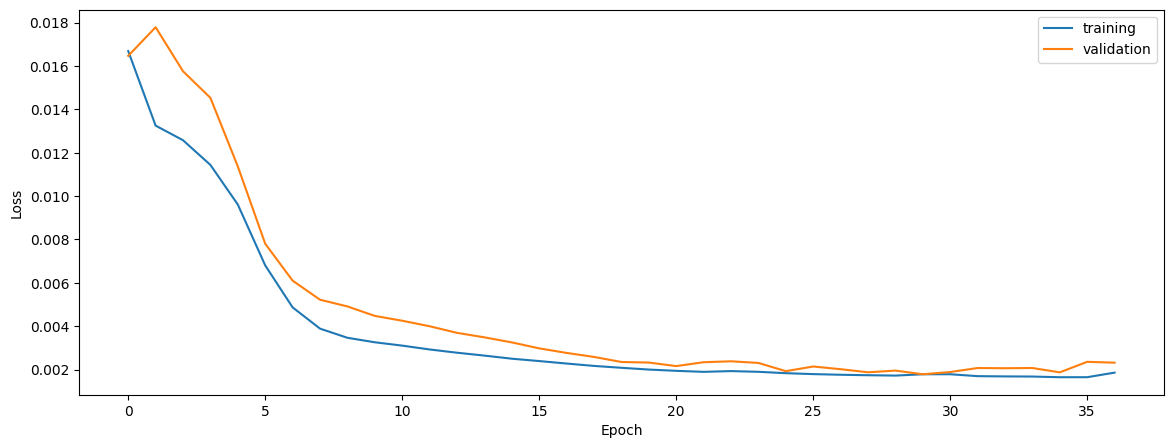

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9302751519382365
0.9457754137327177
0.9432711149049681


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9325352761772133
0.9432888200007934
0.9434850807533098


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.941147329552328
0.9458872702373519
0.9577525346862131


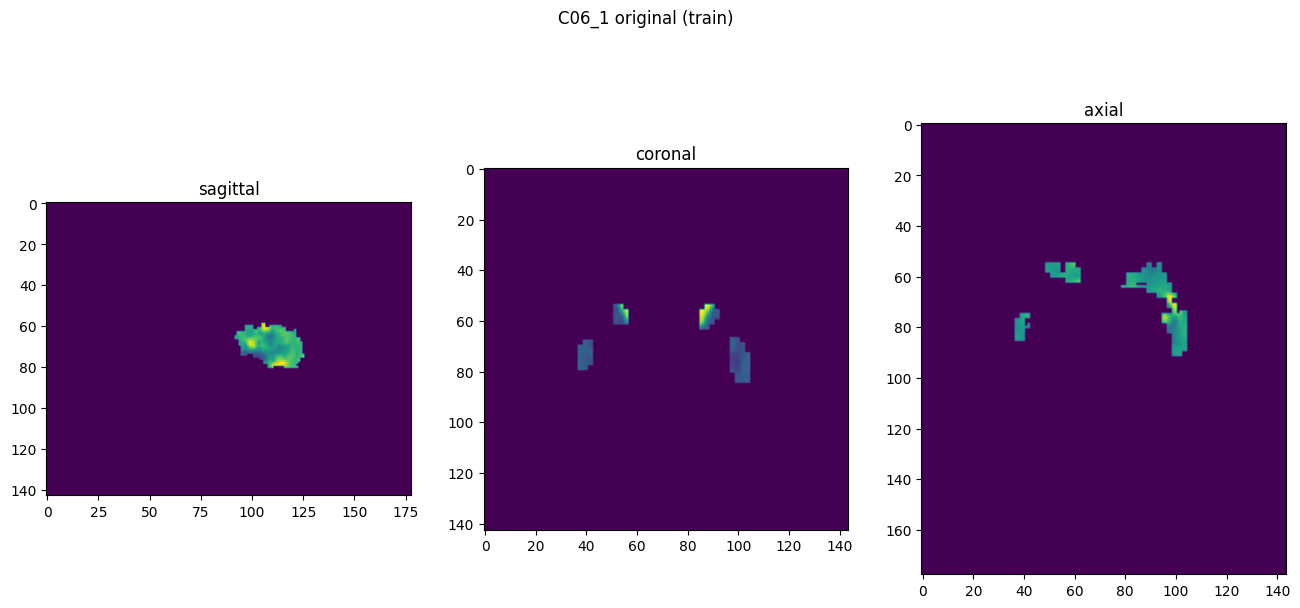

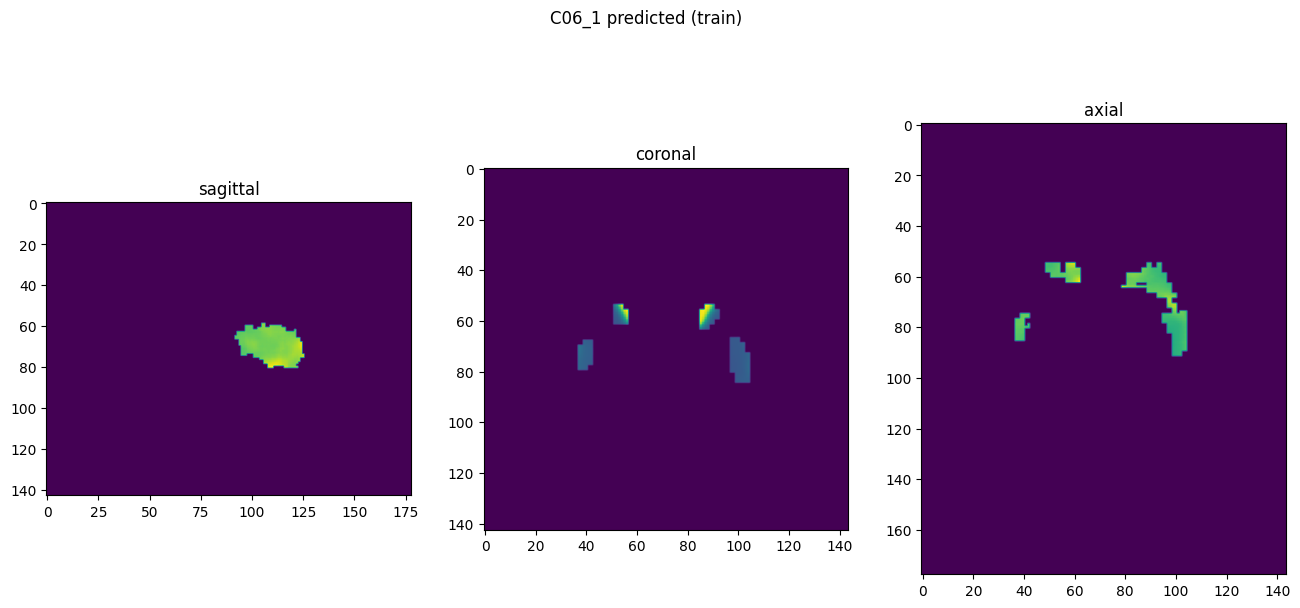

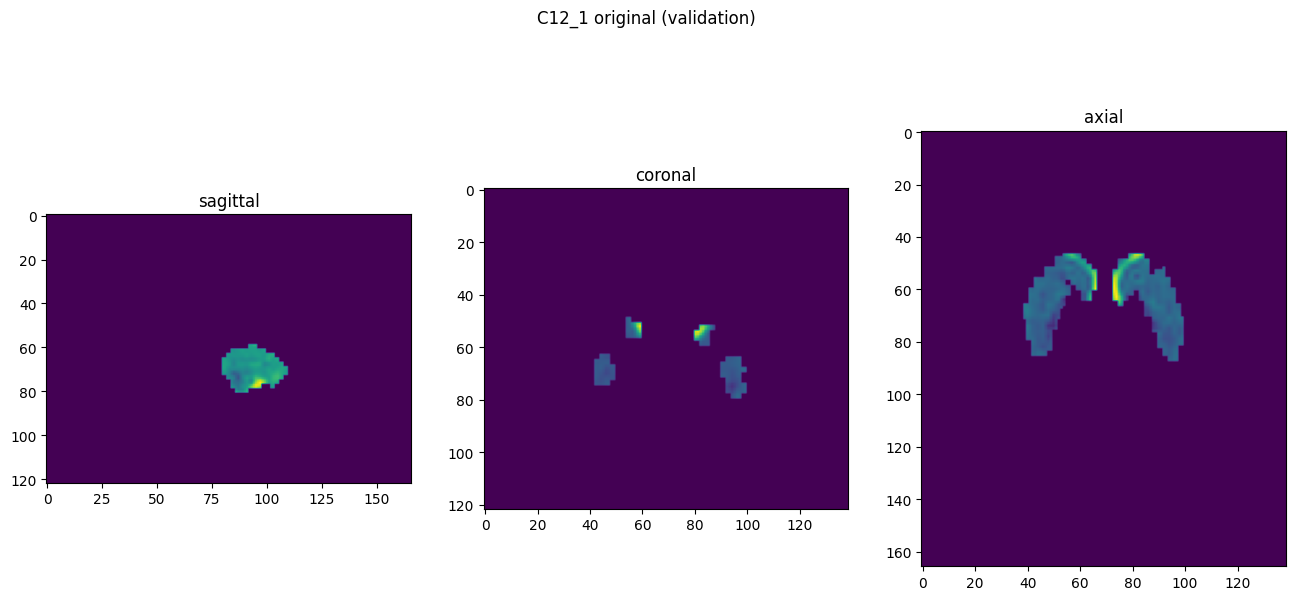

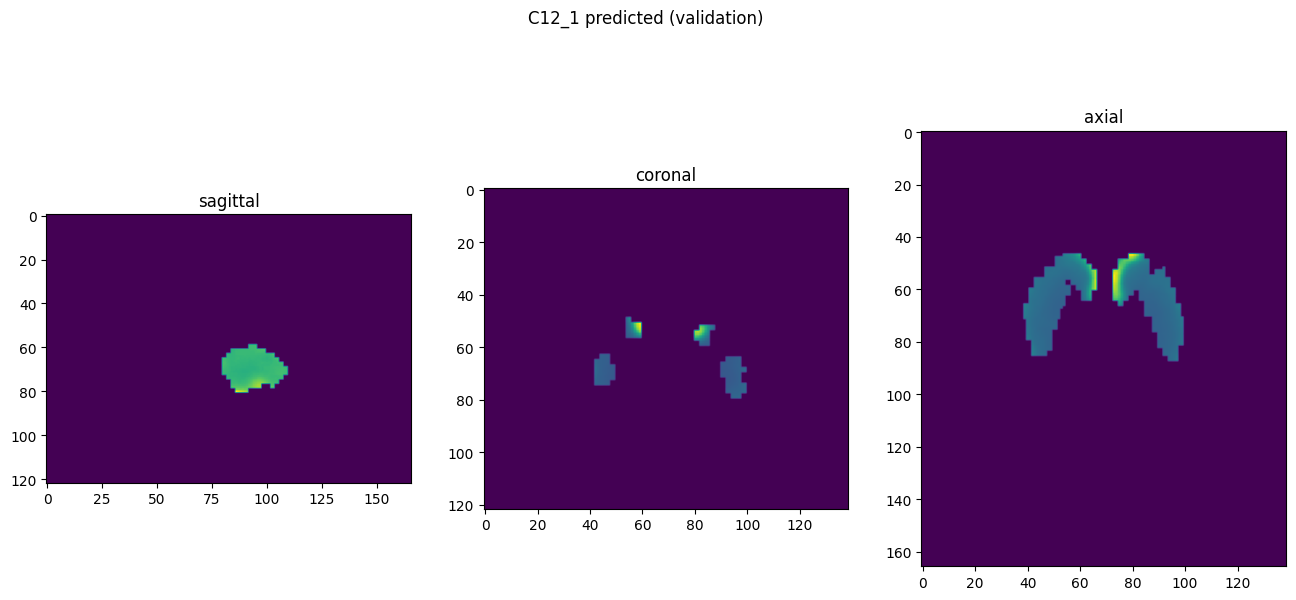

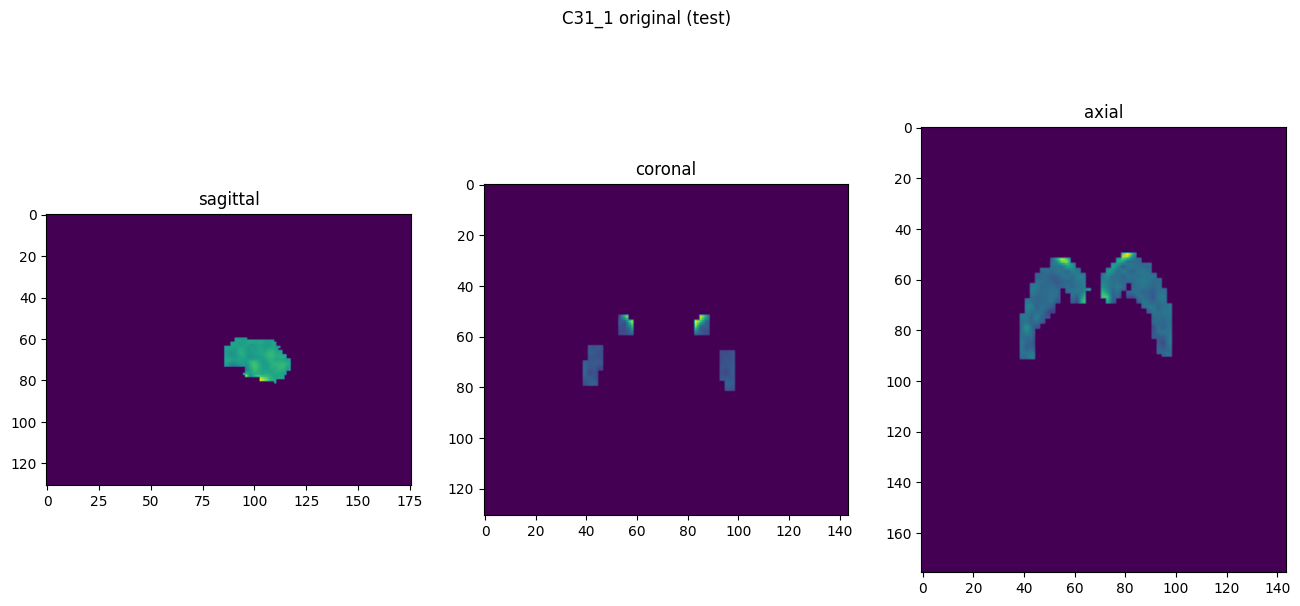

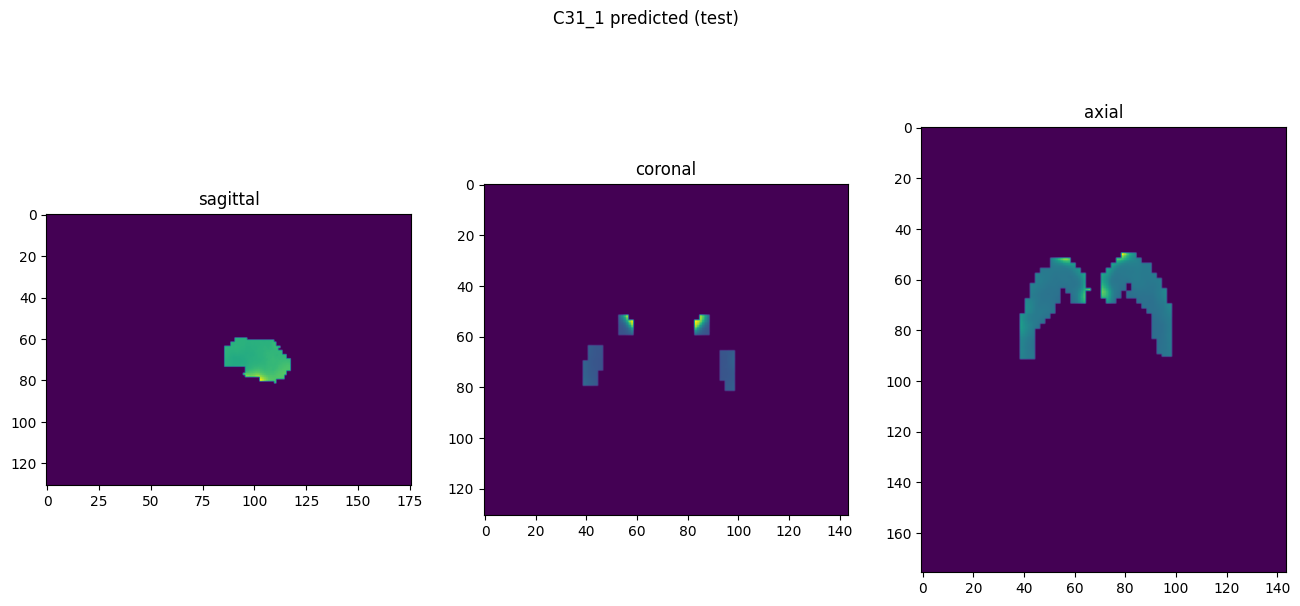

In [10]:
showResults(model, gen, threshold=None, background=False)